
#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/dji.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,RBA,FED,CPI
7706,8/08/2022,32877.36,33109.96,32769.10,32832.54,275350000.0,32832.54,1.85,2.5,125.0
7707,9/08/2022,32807.36,32877.53,32702.66,32774.41,281080000.0,32774.41,1.85,2.5,125.0
7708,10/08/2022,33130.63,33364.41,33130.63,33309.51,311740000.0,33309.51,1.85,2.5,125.0
7709,11/08/2022,33451.51,33651.80,33289.83,33336.67,308030000.0,33336.67,1.85,2.5,125.0
7710,12/08/2022,33430.72,33767.09,33398.32,33761.05,299140000.0,33761.05,1.85,2.5,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# Drop all previous records now in MongoDb
db.dji.drop()

# Insert df records in mongodb
records=df.to_dict('records')
records
db.dji.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.dji.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.dji.delete_one(
    {'Date': last_date}
)



DELETE: 12/08/2022 33761.05


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.dji.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 11/08/2022 33336.67
Previous last date in MongoDb: 11-08-2022. Today's date: 30-08-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = '^DJI'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-10,33364.410156,33130.628906,33130.628906,33309.511719,311740000,33309.511719
2022-08-11,33651.800781,33289.828125,33451.511719,33336.671875,308030000,33336.671875
2022-08-12,33767.089844,33398.320312,33430.718750,33761.050781,299140000,33761.050781
2022-08-15,33954.710938,33582.960938,33710.699219,33912.441406,262670000,33912.441406
2022-08-16,34281.359375,33852.570312,33924.351562,34152.011719,288670000,34152.011719
2022-08-17,34161.011719,33828.410156,34029.550781,33980.320312,281390000,33980.320312
2022-08-18,34043.828125,33844.460938,33981.859375,33999.039062,282550000,33999.039062
2022-08-19,33904.691406,33627.089844,33904.691406,33706.738281,293990000,33706.738281
2022-08-22,33586.589844,33007.628906,33586.589844,33063.609375,308900000,33063.609375


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-11,33651.800781,33289.828125,33451.511719,33336.671875,308030000,33336.671875
2022-08-12,33767.089844,33398.320312,33430.718750,33761.050781,299140000,33761.050781
2022-08-15,33954.710938,33582.960938,33710.699219,33912.441406,262670000,33912.441406
2022-08-16,34281.359375,33852.570312,33924.351562,34152.011719,288670000,34152.011719
2022-08-17,34161.011719,33828.410156,34029.550781,33980.320312,281390000,33980.320312
2022-08-18,34043.828125,33844.460938,33981.859375,33999.039062,282550000,33999.039062
2022-08-19,33904.691406,33627.089844,33904.691406,33706.738281,293990000,33706.738281
2022-08-22,33586.589844,33007.628906,33586.589844,33063.609375,308900000,33063.609375
2022-08-23,33138.261719,32858.890625,33033.519531,32909.589844,251870000,32909.589844


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,11/08/2022,33651.800781,33289.828125,33451.511719,33336.671875,308030000,33336.671875,1.85,2.5,125
1,12/08/2022,33767.089844,33398.320312,33430.718750,33761.050781,299140000,33761.050781,1.85,2.5,125
2,15/08/2022,33954.710938,33582.960938,33710.699219,33912.441406,262670000,33912.441406,1.85,2.5,125
3,16/08/2022,34281.359375,33852.570312,33924.351562,34152.011719,288670000,34152.011719,1.85,2.5,125
4,17/08/2022,34161.011719,33828.410156,34029.550781,33980.320312,281390000,33980.320312,1.85,2.5,125
5,18/08/2022,34043.828125,33844.460938,33981.859375,33999.039062,282550000,33999.039062,1.85,2.5,125
6,19/08/2022,33904.691406,33627.089844,33904.691406,33706.738281,293990000,33706.738281,1.85,2.5,125
7,22/08/2022,33586.589844,33007.628906,33586.589844,33063.609375,308900000,33063.609375,1.85,2.5,125
8,23/08/2022,33138.261719,32858.890625,33033.519531,32909.589844,251870000,32909.589844,1.85,2.5,125
9,24/08/2022,33095.500000,32828.558594,32899.011719,32969.230469,256900000,32969.230469,1.85,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '11/08/2022',
  'High': 33651.80078125,
  'Low': 33289.828125,
  'Open': 33451.51171875,
  'Close': 33336.671875,
  'Volume': 308030000,
  'Adj Close': 33336.671875,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '12/08/2022',
  'High': 33767.08984375,
  'Low': 33398.3203125,
  'Open': 33430.71875,
  'Close': 33761.05078125,
  'Volume': 299140000,
  'Adj Close': 33761.05078125,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '15/08/2022',
  'High': 33954.7109375,
  'Low': 33582.9609375,
  'Open': 33710.69921875,
  'Close': 33912.44140625,
  'Volume': 262670000,
  'Adj Close': 33912.44140625,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '16/08/2022',
  'High': 34281.359375,
  'Low': 33852.5703125,
  'Open': 33924.3515625,
  'Close': 34152.01171875,
  'Volume': 288670000,
  'Adj Close': 34152.01171875,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '17/08/2022',
  'High': 34161.01171875,
  'Low': 33828.41015625,
  'Open': 34029.55078125,
  'Close': 

In [10]:
#INSERT NEW DATA INTO MONGODB
db.dji.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.dji.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('630dc6cfe72dae51c8206e78') '16/08/2022' 33924.3515625
  34281.359375 33852.5703125 34152.01171875 288670000.0 34152.01171875
  1.85 2.5 125.0]
 [ObjectId('630dc6cfe72dae51c8206e79') '17/08/2022' 34029.55078125
  34161.01171875 33828.41015625 33980.3203125 281390000.0 33980.3203125
  1.85 2.5 125.0]
 [ObjectId('630dc6cfe72dae51c8206e7a') '18/08/2022' 33981.859375
  34043.828125 33844.4609375 33999.0390625 282550000.0 33999.0390625 1.85
  2.5 125.0]
 [ObjectId('630dc6cfe72dae51c8206e7b') '19/08/2022' 33904.69140625
  33904.69140625 33627.08984375 33706.73828125 293990000.0 33706.73828125
  1.85 2.5 125.0]
 [ObjectId('630dc6cfe72dae51c8206e7c') '22/08/2022' 33586.58984375
  33586.58984375 33007.62890625 33063.609375 308900000.0 33063.609375
  1.85 2.5 125.0]
 [ObjectId('630dc6cfe72dae51c8206e7d') '23/08/2022' 33033.51953125
  33138.26171875 32858.890625 32909.58984375 251870000.0 32909.58984375
  1.85 2.5 125.0]
 [ObjectId('630dc6cfe72dae51c8206e7e') '24/08/2022' 32899.0117187

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

29/08/2022 32098.990234375


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.dji.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(7723, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6179, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.00192793, 0.00188634, 0.00202596, 0.00199922, 0.00216558,
       0.00186852, 0.0014556 , 0.0032558 , 0.00362118, 0.0033568 ,
       0.00381427, 0.0034875 , 0.00257849, 0.00354097, 0.00267653,
       0.00285773, 0.00308944, 0.00402518, 0.00262602, 0.00321718,
       0.00257849, 0.00289635, 0.00404598, 0.00359445, 0.00353503,
       0.00263791, 0.00322312, 0.00341621, 0.0041648 , 0.00327065,
       0.00324985, 0.00261711, 0.00278347, 0.00427769, 0.0042658 ,
       0.00433116, 0.00360039, 0.00435789, 0.00394795, 0.00389448,
       0.00412024, 0.00456584, 0.00392121, 0.00311618, 0.00252502,
       0.00233193, 0.00280426, 0.00213884, 0.00213884, 0.00294982,
       0.00296467, 0.00354692, 0.00349642, 0.00370733, 0.00415292,
       0.00402518, 0.00369545, 0.00364792, 0.00389448, 0.00281614])]
[0.0029290275242439406]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6119, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6119, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6119/6119 [==============================] - 1418s 231ms/step - loss: 1.6045e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

55.618847605650814

C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/831020177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


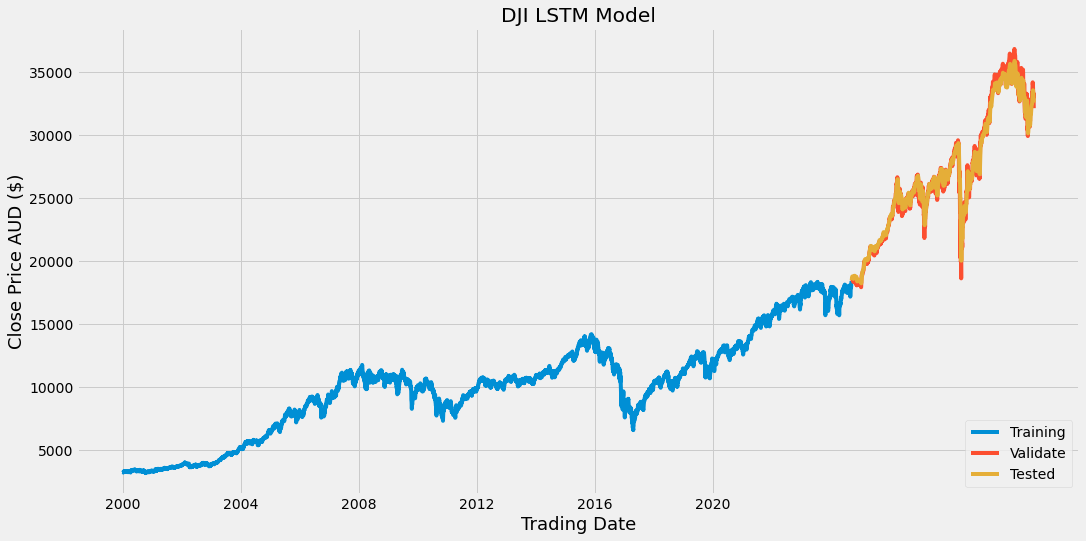

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('DJI LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/dji_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of              Close   Predictions  Difference
6179  18506.410000  18441.556641   64.853359
6180  18516.550000  18533.738281  -17.188281
6181  18533.050000  18608.052734  -75.002734
6182  18559.010000  18662.335938 -103.325938
6183  18595.030000  18702.408203 -107.378203
...            ...           ...         ...
7718  32909.589844  33255.406250 -345.816406
7719  32969.230469  33004.152344  -34.921875
7720  33291.781250  32817.417969  474.363281
7721  32283.400391  32774.203125 -490.802734
7722  32098.990234  32546.828125 -447.837891

[1544 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.dji.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

29/08/2022 Last close $32098.990234375 Predicted next day share price $32158.45


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/dji_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list dji_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/dji_model.sav')

In [32]:
# query the dji collection and load into dataframe

df_mongo = pd.DataFrame(list(db.dji.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[32819.5       ],
       [32641.85      ],
       [32824.37      ],
       [32267.78      ],
       [31387.84      ],
       [30373.72      ],
       [30144.23      ],
       [30185.08      ],
       [29740.35      ],
       [29653.29      ],
       [30074.69      ],
       [30166.01      ],
       [30293.4       ],
       [30846.94      ],
       [31351.37      ],
       [30934.33      ],
       [30894.53      ],
       [30431.87      ],
       [30487.79      ],
       [30355.12      ],
       [30794.84      ],
       [31154.64      ],
       [31212.45      ],
       [31114.4       ],
       [30860.51      ],
       [30514.61      ],
       [30143.93      ],
       [30775.37      ],
       [30982.97      ],
       [31165.91      ],
       [31646.95      ],
       [31534.08      ],
       [31731.47      ],
       [31821.67      ],
       [31705.36      ],
       [31799.43      ],
       [31982.61      ],
       [32493.02      ],
       [32640.79      ],
       [32387.12      ],


#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/dji_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_dji(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_dji(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[32486.99,
 32404.49,
 32376.69,
 32372.99,
 32380.55,
 32393.58,
 32409.12,
 32425.48,
 32441.61,
 32456.87,
 32474.19,
 32487.99,
 32500.23,
 32511.19,
 32520.86,
 32529.38,
 32536.87,
 32543.51,
 32549.43,
 32554.79,
 32559.7,
 32564.27,
 32568.58,
 32572.72,
 32576.73,
 32580.66,
 32584.54,
 32591.53,
 32596.37,
 32601.07,
 32604.11,
 32608.79,
 32611.66,
 32615.84,
 32619.9,
 32622.79,
 32623.99,
 32627.16,
 32630.13,
 32633.04,
 32635.96,
 32638.9,
 32641.89,
 32644.92,
 32647.99,
 32651.1,
 32654.24,
 32657.42,
 32660.62,
 32663.86,
 32667.11,
 32670.39,
 32673.68,
 32676.69,
 32673.16,
 32670.71,
 32670.7,
 32670.2,
 32656.21,
 32652.32,
 32656.28,
 32653.48,
 32651.27,
 32649.38,
 32647.87,
 32646.66,
 32645.71,
 32644.97,
 32644.43,
 32644.03,
 32643.83,
 32643.7,
 32643.66,
 32643.68,
 32643.75,
 32643.86,
 32643.98,
 32644.12,
 32644.27,
 32644.43,
 32644.59,
 32644.74,
 32644.9,
 32645.05,
 32645.21,
 32645.36,
 32645.51,
 32645.68,
 32645.84,
 32645.99,
 32646.13,
 32646.

In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [35]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-08-31 00:00:00 2022-08-30 00:00:00
5:21:53.540261
[[ObjectId('630dc684ae0967d01293931d') 199 '05-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d01293931e') 200 '06-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d01293931f') 201 '07-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939320') 202 '08-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939321') 203 '09-06-2023' 'Friday']
 [ObjectId('630dc684ae0967d012939322') 204 '12-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d012939323') 205 '13-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d012939324') 206 '14-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939325') 207 '15-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939326') 208 '16-06-2023' 'Friday']]


In [36]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,31-08-2022,Wednesday
1,2,01-09-2022,Thursday
2,3,02-09-2022,Friday
3,4,05-09-2022,Monday
4,5,06-09-2022,Tuesday
...,...,...,...
203,204,12-06-2023,Monday
204,205,13-06-2023,Tuesday
205,206,14-06-2023,Wednesday
206,207,15-06-2023,Thursday


In [37]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/1116303769.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


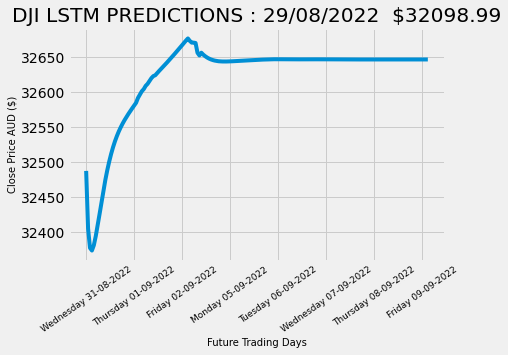

In [38]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('DJI LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/dji_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('630dc684ae0967d012939257'), 'Count': 1, 'Date': '31-08-2022', 'DOW': 'Wednesday', 'Price': 32486.99}


In [40]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6179 7723 7891


C:\Users\antoi\AppData\Local\Temp/ipykernel_22120/618951410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


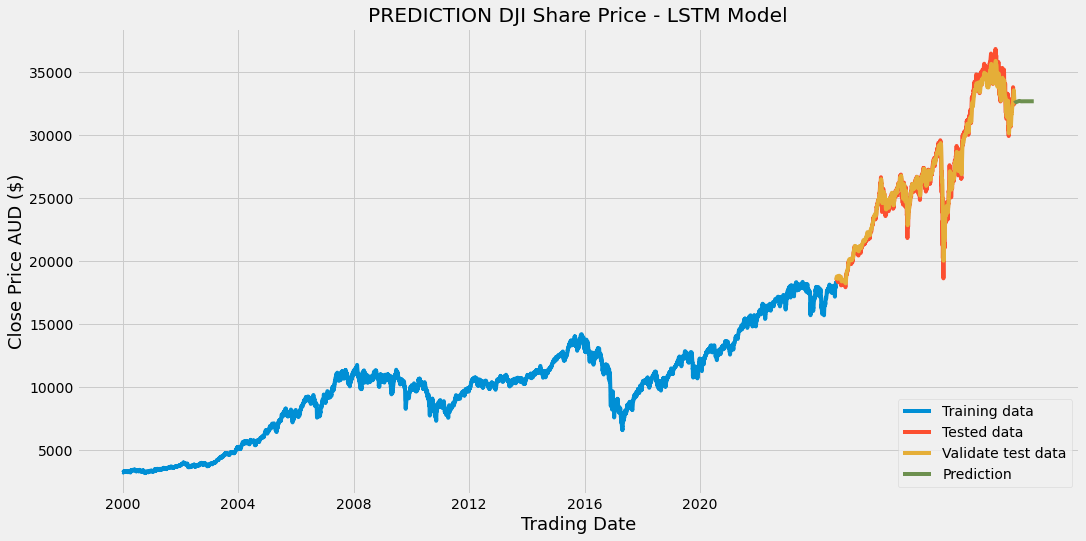

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION DJI Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/dji_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Query all
name = 'DJI'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('630c8ec1db7b37b4b4059fab'), 'model': 'LSTM', 'name': 'DJI', 'date': '26/08/2022', 'predicted': 32036.17, 'actual': 32283.4, 'difference': -247.23, 'rmse': 300.89437}


In [43]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

In [44]:
# Set keys and values of company
name = 'DJI'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 29/08/2022,predicted $32158.45, actual $32098.99, difference 59.45999999999913, rmse 55.61885


In [45]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('630dcc6fe72dae51c8206e83'), 'model': 'LSTM', 'name': 'DJI', 'date': '29/08/2022', 'predicted': 32158.45, 'actual': 32098.99, 'difference': 59.46, 'rmse': 55.61885}


In [46]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'

In [47]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'